# Riskfolio-Lib Tutorial: 
<br>__[Financionerioncios](https://financioneroncios.wordpress.com)__
<br>__[Orenji](https://www.orenj-i.net)__
<br>__[Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/en/latest/)__
<br>__[Dany Cajas](https://www.linkedin.com/in/dany-cajas/)__
<a href='https://ko-fi.com/B0B833SXD' target='_blank'><img height='36' style='border:0px;height:36px;' src='https://cdn.ko-fi.com/cdn/kofi1.png?v=2' border='0' alt='Buy Me a Coffee at ko-fi.com' /></a> 

## Tutorial 5: Multi Assets Algorithmic Trading Backtesting with Backtrader

For this tutorial we need matplotlib=3.2.2 because backtrader only works with this version of matplotlib. However, this version of matplotlib give us an error in plot_pie function.

## 1. Downloading the data:

In [43]:
%matplotlib inline

In [168]:
import pandas as pd
import datetime
import yfinance as yf
import backtrader as bt
import numpy as np
import warnings
import matplotlib as plt

warnings.filterwarnings("ignore")
plt.rc('font', family='Pretendard')
pd.options.display.float_format = '{:.4f}'.format

# Date range
start = '2010-01-01'
end = '2023-05-25'

# Tickers of assets
ticker_labes = {
    'ticker': ['^KS200', '229200.KS', '143850.KS', '195930.KS', '238720.KS', '192090.KS', '148070.KS', '136340.KS', '182490.KS', '280940.KS', '130680.KS', '114800.KS', '138230.KS', '139660.KS', '130730.KS', 'SPY'],
    'labels': ['KOSPI', 'KOSDAQ', 'S&P500', 'STOXX50', 'Nikkei225', 'CSI300', '국채10년', '우량회사채', '해외채권', '금', 'WTI', 'KOSPI-Short', 'US-Long', 'US-Short', 'MMF', 'SPY']
}

# Downloading data
prices = yf.download(ticker_labes['ticker'], start=start, end=end)
prices = prices.dropna()

[*********************100%***********************]  16 of 16 completed


In [169]:
column_names = prices.columns
matched_columns = [(label, ticker_labes['labels'][ticker_labes['ticker'].index(ticker)]) for label, ticker in column_names]

# Convert matched_columns to a pandas MultiIndex
matched_columns = pd.MultiIndex.from_tuples(matched_columns)

# Assign the matched columns to the prices dataframe
prices.columns = matched_columns
prices = prices.sort_index(axis=1)

In [170]:
benchmark_asset_list = []
asset_list = []

for i in range(0, 16):
    ticker = prices.columns[i][1]
    benchmark_asset_list.append(ticker)
    if ticker != 'SPY':
        asset_list.append(ticker)

print(benchmark_asset_list)
print(asset_list)


['CSI300', 'KOSDAQ', 'KOSPI', 'KOSPI-Short', 'MMF', 'Nikkei225', 'S&P500', 'SPY', 'STOXX50', 'US-Long', 'US-Short', 'WTI', '국채10년', '금', '우량회사채', '해외채권']
['CSI300', 'KOSDAQ', 'KOSPI', 'KOSPI-Short', 'MMF', 'Nikkei225', 'S&P500', 'STOXX50', 'US-Long', 'US-Short', 'WTI', '국채10년', '금', '우량회사채', '해외채권']


## 2. Building the Backtest Function with Backtrader

### 2.1 Defining Backtest Function

In [171]:
############################################################
# Defining the backtest function 
############################################################

def backtest(datas, strategy, start, end, plot=False, **kwargs):
    cerebro = bt.Cerebro()

    # Here we add transaction costs and other broker costs
    cerebro.broker.setcash(1000000.0)
    cerebro.broker.setcommission(commission=0.0015) # Commission 0.5%
    cerebro.broker.set_slippage_perc(0.000, # Slippage 0.5%
                                     slip_open=True,
                                     slip_limit=True,
                                     slip_match=True,
                                     slip_out=False)
    for data in datas:
        cerebro.adddata(data)

    # Here we add the indicators that we are going to store
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
    cerebro.addanalyzer(bt.analyzers.Returns)
    cerebro.addanalyzer(bt.analyzers.DrawDown)
    cerebro.addstrategy(strategy, **kwargs)
    cerebro.addobserver(bt.observers.Value)
    cerebro.addobserver(bt.observers.DrawDown)
    results = cerebro.run(stdstats=False)
    if plot:
        cerebro.plot(iplot=False, start=start, end=end)
    return (results[0].analyzers.drawdown.get_analysis()['max']['drawdown'],
            results[0].analyzers.returns.get_analysis()['rnorm100'],
            results[0].analyzers.sharperatio.get_analysis()['sharperatio'])

### 2.2 Building Data Feeds for Backtesting

In [172]:
############################################################
# Create objects that contain the prices of assets
############################################################

# Creating Assets bt.feeds
assets_prices = []
for i in ticker_labes['labels']:
    if i != 'SPY':
        prices_ = prices.drop(columns='Adj Close').loc[:, (slice(None), i)].dropna()
        prices_.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
        assets_prices.append(bt.feeds.PandasData(dataname=prices_, plot=False))

# Creating Benchmark bt.feeds        
prices_ = prices.drop(columns='Adj Close').loc[:, (slice(None), 'SPY')].dropna()
prices_.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
benchmark = bt.feeds.PandasData(dataname=prices_, plot=False)

display(prices_.head())

,Close,High,Low,Open,Volume
Date,,,,,
2017-11-09,25817.0013%,25839.0015%,25635.9985%,25773.0011%,9508550000.0000%
2017-11-10,25808.9996%,25829.0009%,25736.9995%,25773.0011%,5998470000.0000%
2017-11-13,25832.9987%,25858.9996%,25726.9989%,25730.9998%,5022860000.0000%
2017-11-14,25773.0011%,25785.0006%,25651.9989%,25741.0004%,6131520000.0000%
2017-11-15,25644.0002%,25722.0001%,25563.0005%,25661.9995%,8081150000.0000%


## 3. Building Strategies with Backtrader

### 3.1 Buy and Hold SPY

In [173]:
############################################################
# Building the Buy and Hold strategy
############################################################

class BuyAndHold(bt.Strategy):

    def __init__(self):
        self.counter = 0

    def next(self):
        if self.counter >= 300:
            if self.getposition(self.data).size == 0:
                self.order_target_percent(self.data, target=0.99)
        self.counter += 1 

If you have an error related to 'warnings' modules when you try to plot, you must modify the 'locator.py' file from backtrader library following the instructions in this __[link](https://community.backtrader.com/topic/981/importerror-cannot-import-name-min_per_hour-when-trying-to-plot/8)__.

In [174]:
prices.shape[0]

1305

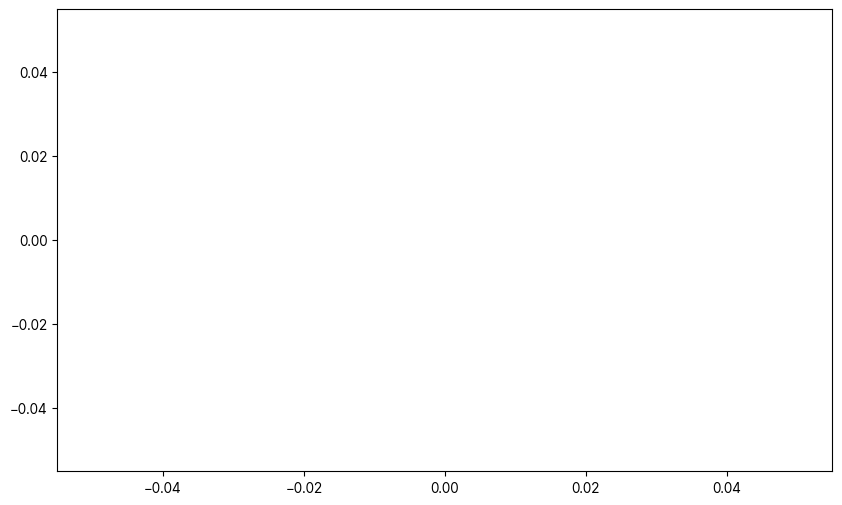

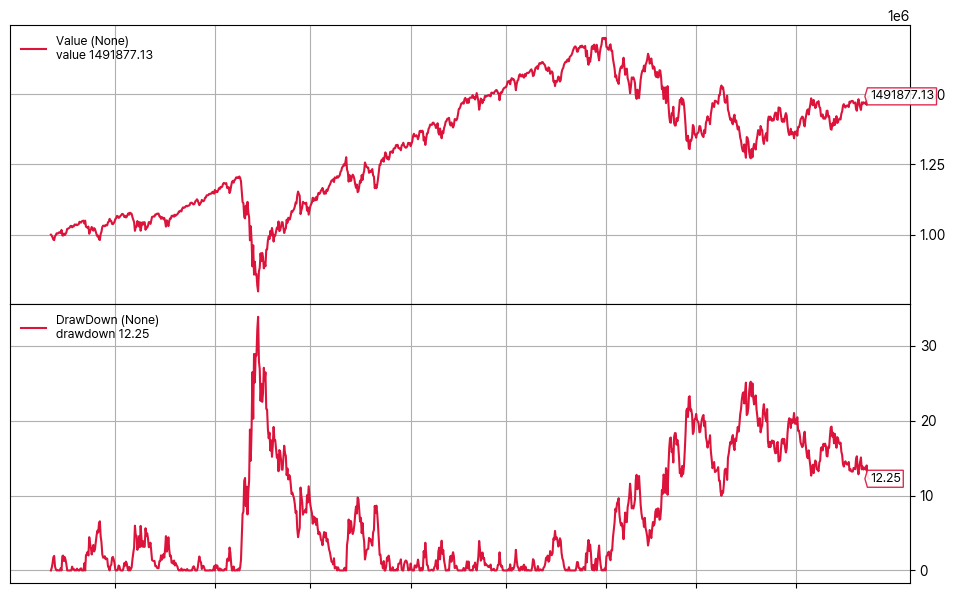

In [175]:
############################################################
# Run the backtest for the selected period
############################################################
%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
plt.rc('font', family='Pretendard')
plt.plot() # We need to do this to avoid errors in inline plot

start = 300
end = prices.shape[0] - 1

dd, cagr, sharpe = backtest([benchmark],
                            BuyAndHold,
                            start=start,
                            end=end,
                            plot=True)

In [176]:
############################################################
# Show Buy and Hold Strategy Stats 
############################################################

print(f"Max Drawdown: {dd:.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Sharpe: {sharpe:.3f}")

Max Drawdown: 33.88%
CAGR: 7.80%
Sharpe: 0.478


### 3.2 Rebalancing Quarterly using Riskfolio-Lib

In [177]:
############################################################
# Calculate assets returns
############################################################

pd.options.display.float_format = '{:.4%}'.format

data = prices.loc[:, ('Adj Close', slice(None))]
data.columns = benchmark_asset_list
data = data.drop(columns=['SPY']).dropna()

returns = data.pct_change().dropna()
returns.columns = asset_list
display(returns.head())

,CSI300,KOSDAQ,KOSPI,KOSPI-Short,MMF,Nikkei225,S&P500,STOXX50,US-Long,US-Short,WTI,국채10년,금,우량회사채,해외채권
Date,,,,,,,,,,,,,,,
2017-11-10,1.6520%,1.9814%,-0.3500%,0.3439%,-0.0049%,-0.7950%,-0.2113%,-0.9583%,0.1310%,-0.0448%,0.3606%,-0.0087%,-0.3014%,-0.0049%,-0.0902%
2017-11-13,0.3792%,4.0048%,-0.4852%,0.4284%,0.0049%,-1.3937%,-0.2443%,-0.3366%,0.3489%,-0.3136%,-0.2395%,-0.3651%,0.6549%,-0.0980%,0.0000%
2017-11-14,-0.3778%,3.8506%,-0.2124%,0.0853%,-0.0049%,-0.1060%,-0.1143%,-0.8020%,-0.2173%,0.2247%,-0.6002%,-0.1221%,-0.1502%,-0.0147%,-0.3610%
2017-11-15,-1.3543%,2.6799%,-0.4346%,0.4263%,0.0098%,-1.4149%,-0.0817%,-0.7660%,-0.5227%,0.4484%,-2.8986%,0.1441%,-0.2005%,0.0245%,0.0453%
2017-11-16,-0.1098%,1.8949%,0.6593%,-0.5093%,-0.0049%,1.2558%,0.0000%,0.4288%,-0.9632%,1.1607%,0.7463%,0.3358%,0.3014%,0.0736%,-0.2263%


In [178]:
############################################################
# Selecting Dates for Rebalancing
############################################################

# Selecting last day of month of available data
index = returns.groupby([returns.index.year, returns.index.month]).tail(1).index
index_2 = returns.index

# Quarterly Dates
index = [x for x in index if float(x.month) % 3.0 == 0 ] 

# Dates where the strategy will be backtested
index_ = [index_2.get_loc(x) for x in index if index_2.get_loc(x) > 1000]

In [179]:
Asset = ['KOSPI', 'KOSDAQ', 'S&P500', 'STOXX50', 'Nikkei225', 'CSI300', '국채10년', '우량회사채', '해외채권', '금', 'WTI', 'KOSPI-Short', 'US-Long', 'US-Short', 'MMF']
Class = ['DS', 'DS', 'FS', 'FS', 'FS', 'FS', 'Bond', 'Bond', 'Bond', 'COM', 'COM', 'Inverse', 'FX', 'FX', 'Cash']
Disabled = [False] * 27
Type = ['Classes'] * 11 + ['Assets'] * 16
Set = ['Class'] * 11 + [''] * 16
Position = ['DS', 'DS', 'FS', 'FS', 'Bond', 'Bond', 'COM', 'COM', 'Inverse', 'FX', 'Cash',
            'KOSPI', 'KOSDAQ', 'S&P500', 'STOXX50', 'Nikkei225', 'CSI300',
            '국채10년', '우량회사채', '해외채권',
            '금', 'WTI', 'KOSPI-Short', 'US-Long', 'US-Short',
            'MMF', '해외채권']
TypeRelative=  [''] * 27
RelativeSet =  [''] * 27
Relative = [''] * 27
Factor = [''] * 27

# DS상하한(2), FS상하한(2), Bond상하한(2), COM상하한(2), Inverse(1), FX(1), Cash(1)
# KOSPI상한, #KOSDAQ상한, S&P상한, STO상한, Nik상한, CSI상한,
# 국채상한, 회사채상한, 해채상한,
# 금, WTI, 코숏, 달러롱, 달러숏,
# 현금하한, 해채하한
Sign = ['<=', '>=', '<=', '>=', '<=', '>=', '<=', '>=', '<=', '<=', '<=', 
        '<=', '<=', '<=', '<=', '<=', '<=',
        '<=', '<=', '<=',
        '<=', '<=', '<=', '<=', '<=',
        '>=', '>=']

Weight = [0.40, 0.10, 0.40, 0.10, 0.60, 0.20, 0.20, 0.05, 0.20, 0.20, 0.50,
          0.40, 0.20, 0.20, 0.20, 0.20, 0.20,
          0.50, 0.40, 0.40,
          0.15, 0.15, 0.20, 0.20, 0.20,
          0.01, 0.05]

constraints_list = [Asset, Class, Disabled, Type, Set, Position, Sign, Weight]
for i in constraints_list:
    print(constraints_list.index(i) , len(i))

0 15
1 15
2 27
3 27
4 27
5 27
6 27
7 27


In [180]:
asset_classes = {'Assets': Asset,
                 'Class': Class
                 }

asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=['Assets'])

constraints = {'Disabled': Disabled,
               'Type': Type,
               'Set': Set,
               'Position': Position,
               'Sign': Sign,
               'Weight': Weight,
               'Type Relative': TypeRelative,
               'Relative Set': RelativeSet,
               'Relative': Relative,
               'Factor': Factor
}

constraints = pd.DataFrame(constraints)

display(constraints)

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,False,Classes,Class,DS,<=,40.0000%,,,,
1,False,Classes,Class,DS,>=,10.0000%,,,,
2,False,Classes,Class,FS,<=,40.0000%,,,,
3,False,Classes,Class,FS,>=,10.0000%,,,,
4,False,Classes,Class,Bond,<=,60.0000%,,,,
5,False,Classes,Class,Bond,>=,20.0000%,,,,
6,False,Classes,Class,COM,<=,20.0000%,,,,
7,False,Classes,Class,COM,>=,5.0000%,,,,
8,False,Classes,Class,Inverse,<=,20.0000%,,,,
9,False,Classes,Class,FX,<=,20.0000%,,,,


In [181]:
asset_classes

,Assets,Class
5,CSI300,FS
1,KOSDAQ,DS
0,KOSPI,DS
11,KOSPI-Short,Inverse
14,MMF,Cash
4,Nikkei225,FS
2,S&P500,FS
3,STOXX50,FS
12,US-Long,FX
13,US-Short,FX


In [182]:
############################################################
# Building constraint matrixes for Riskfolio Lib
############################################################

import riskfolio as rp

A, B = rp.assets_constraints(constraints, asset_classes)

In [183]:
asset_classes

,Assets,Class
5,CSI300,FS
1,KOSDAQ,DS
0,KOSPI,DS
11,KOSPI-Short,Inverse
14,MMF,Cash
4,Nikkei225,FS
2,S&P500,FS
3,STOXX50,FS
12,US-Long,FX
13,US-Short,FX


In [184]:
%%time
############################################################
# Building a loop that estimate optimal portfolios on
# rebalancing dates
############################################################

models = {}

# rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM',
#        'CVaR', 'WR', 'MDD', 'ADD', 'CDaR']

rms = ['MV', 'CVaR', 'WR', 'CDaR']

for j in rms:
    
    weights = pd.DataFrame([])

    for i in index_:
        Y = returns.iloc[i-1000:i,:] # taking last 4 month (250 trading days per year)

        # Building the portfolio object
        port = rp.Portfolio(returns=Y)
        
        # Add portfolio constraints
        port.ainequality = A
        port.binequality = B
        
        # Calculating optimum portfolio

        # Select method and estimate input parameters:

        method_mu='hist' # Method to estimate expected returns based on historical data.
        method_cov='hist' # Method to estimate covariance matrix based on historical data.

        port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)
        
        # Estimate optimal portfolio:
        
        port.solvers = ['MOSEK']
        port.alpha = 0.05
        model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
        rm = j # Risk measure used, this time will be variance
        obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
        hist = True # Use historical scenarios for risk measures that depend on scenarios
        rf = 0 # Risk free rate
        l = 0 # Risk aversion factor, only useful when obj is 'Utility'

        w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

        if w is None:
            w = weights.tail(1).T
        weights = pd.concat([weights, w.T], axis = 0)
    
    models[j] = weights.copy()
    models[j].index = index_

The problem doesn't have a solution with actual input parameters
CPU times: total: 922 ms
Wall time: 1.87 s


In [185]:
############################################################
# Building the Asset Allocation Class
############################################################

class AssetAllocation(bt.Strategy):

    def __init__(self):

        j = 0
        for i in assets:
            setattr(self, i, self.datas[j])
            j += 1
        
        self.counter = 0
        
    def next(self):
        if self.counter in weights.index.tolist():
            for i in assets:
                w = weights.loc[self.counter, i]
                self.order_target_percent(getattr(self, i), target=w)
        self.counter += 1

In [186]:
returns

,CSI300,KOSDAQ,KOSPI,KOSPI-Short,MMF,Nikkei225,S&P500,STOXX50,US-Long,US-Short,WTI,국채10년,금,우량회사채,해외채권
Date,,,,,,,,,,,,,,,
2017-11-10,1.6520%,1.9814%,-0.3500%,0.3439%,-0.0049%,-0.7950%,-0.2113%,-0.9583%,0.1310%,-0.0448%,0.3606%,-0.0087%,-0.3014%,-0.0049%,-0.0902%
2017-11-13,0.3792%,4.0048%,-0.4852%,0.4284%,0.0049%,-1.3937%,-0.2443%,-0.3366%,0.3489%,-0.3136%,-0.2395%,-0.3651%,0.6549%,-0.0980%,0.0000%
2017-11-14,-0.3778%,3.8506%,-0.2124%,0.0853%,-0.0049%,-0.1060%,-0.1143%,-0.8020%,-0.2173%,0.2247%,-0.6002%,-0.1221%,-0.1502%,-0.0147%,-0.3610%
2017-11-15,-1.3543%,2.6799%,-0.4346%,0.4263%,0.0098%,-1.4149%,-0.0817%,-0.7660%,-0.5227%,0.4484%,-2.8986%,0.1441%,-0.2005%,0.0245%,0.0453%
2017-11-16,-0.1098%,1.8949%,0.6593%,-0.5093%,-0.0049%,1.2558%,0.0000%,0.4288%,-0.9632%,1.1607%,0.7463%,0.3358%,0.3014%,0.0736%,-0.2263%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-16,0.1502%,1.0250%,0.2620%,-0.4246%,0.0000%,0.9436%,-0.2408%,-0.5236%,0.1384%,-0.1691%,1.5524%,0.2762%,0.4591%,0.1053%,0.1651%
2023-05-17,-1.3000%,2.5974%,0.3996%,-0.3198%,0.0000%,0.8856%,-0.3043%,-0.0658%,-0.2419%,0.1694%,-0.8917%,-0.0888%,0.0762%,-0.0430%,-0.2060%
2023-05-19,-1.5198%,0.0791%,2.3331%,-2.2460%,0.0097%,2.3653%,2.2211%,1.7775%,-0.6235%,0.7328%,3.2134%,-0.7070%,0.9132%,-0.1243%,0.0000%


In [187]:
############################################################
# Backtesting Mean Variance Strategy
############################################################

assets = returns.columns.tolist()
weights = models['MV']
start = 1033

In [188]:
weights

,CSI300,KOSDAQ,KOSPI,KOSPI-Short,MMF,Nikkei225,S&P500,STOXX50,US-Long,US-Short,WTI,국채10년,금,우량회사채,해외채권
1033,0.7329%,0.0000%,10.0000%,9.7116%,1.0000%,0.0000%,9.4438%,0.0000%,20.0000%,0.0000%,1.8699%,0.0000%,3.1301%,39.1116%,5.0000%
1090,3.2481%,0.0000%,10.0000%,11.5055%,22.1075%,1.6627%,6.4762%,0.0000%,20.0000%,0.0000%,2.2390%,0.0000%,2.7610%,15.0000%,5.0000%
1151,3.8296%,0.0000%,10.0000%,11.1645%,22.7669%,1.8806%,5.3583%,0.0000%,20.0000%,0.0000%,1.3060%,0.0000%,3.6940%,15.0000%,5.0000%
1211,6.7311%,0.0000%,10.0000%,10.8456%,17.8958%,0.6811%,8.6995%,0.1469%,20.0000%,0.0000%,1.7993%,0.0000%,3.2007%,12.6483%,7.3517%
1270,3.7134%,0.0000%,10.0000%,7.9068%,27.0764%,1.3968%,4.2636%,0.6430%,19.9999%,0.0000%,1.8115%,0.0000%,3.1885%,14.9999%,5.0001%


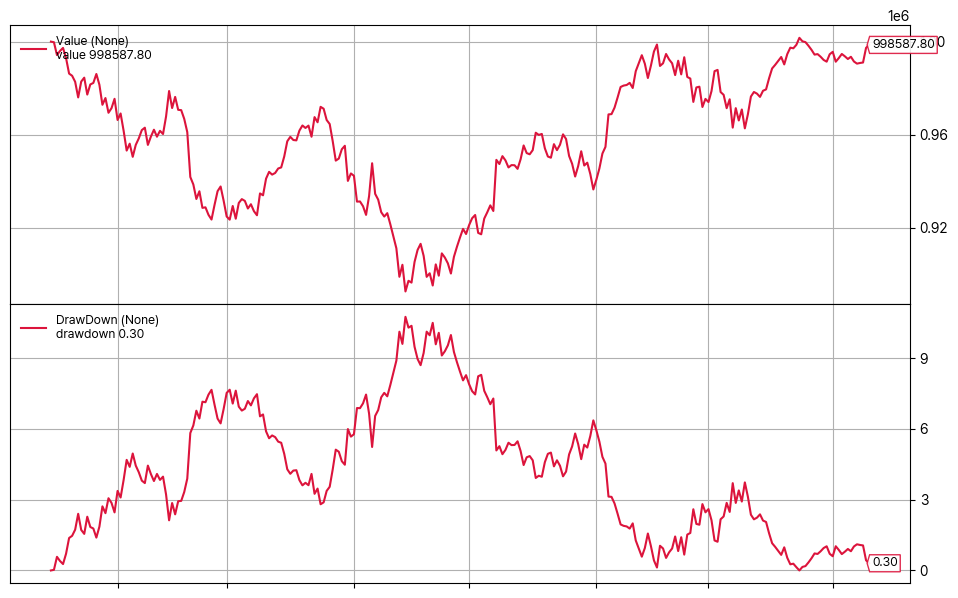

In [214]:
dd, cagr, sharpe = backtest(assets_prices,
                            AssetAllocation,
                            start=start,
                            end=end,
                            plot=True)

In [215]:
############################################################
# Show Mean Variance Strategy Stats 
############################################################

print(f"Max Drawdown: {dd:.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Sharpe: {sharpe:.3f}")

Max Drawdown: 10.75%
CAGR: -0.01%
Sharpe: 0.015


In [216]:
models['MV']

,CSI300,KOSDAQ,KOSPI,KOSPI-Short,MMF,Nikkei225,S&P500,STOXX50,US-Long,US-Short,WTI,국채10년,금,우량회사채,해외채권
1033,0.7329%,0.0000%,10.0000%,9.7116%,1.0000%,0.0000%,9.4438%,0.0000%,20.0000%,0.0000%,1.8699%,0.0000%,3.1301%,39.1116%,5.0000%
1090,3.2481%,0.0000%,10.0000%,11.5055%,22.1075%,1.6627%,6.4762%,0.0000%,20.0000%,0.0000%,2.2390%,0.0000%,2.7610%,15.0000%,5.0000%
1151,3.8296%,0.0000%,10.0000%,11.1645%,22.7669%,1.8806%,5.3583%,0.0000%,20.0000%,0.0000%,1.3060%,0.0000%,3.6940%,15.0000%,5.0000%
1211,6.7311%,0.0000%,10.0000%,10.8456%,17.8958%,0.6811%,8.6995%,0.1469%,20.0000%,0.0000%,1.7993%,0.0000%,3.2007%,12.6483%,7.3517%
1270,3.7134%,0.0000%,10.0000%,7.9068%,27.0764%,1.3968%,4.2636%,0.6430%,19.9999%,0.0000%,1.8115%,0.0000%,3.1885%,14.9999%,5.0001%


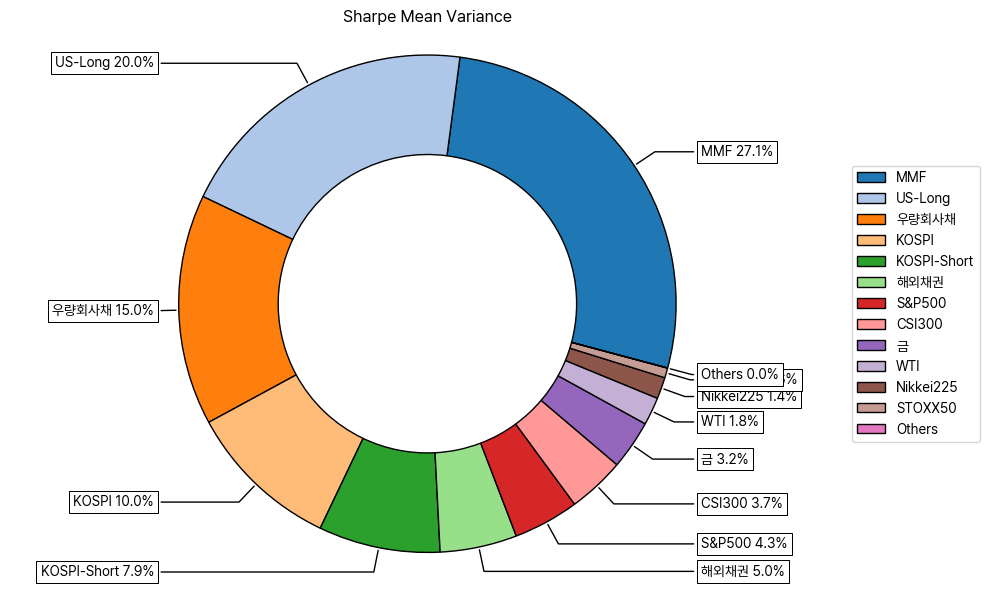

In [217]:
############################################################
# Plotting the composition of the last MV portfolio
############################################################

w = pd.DataFrame(models['MV'].iloc[-1,:])

# We need matplotlib >= 3.3.0 to use this function
ax = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0.001, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

#w.plot.pie(subplots=True, figsize=(8, 8))

In [218]:
############################################################
# Composition per Asset
############################################################

w_classes = pd.concat([asset_classes.set_index('Assets'), w], axis=1)
w_classes.rename(columns={1270 : 'Weights'}, inplace=True)
w_classes = w_classes.sort_values('Class')
w_classes

,Class,Weights
국채10년,Bond,0.0000%
우량회사채,Bond,14.9999%
해외채권,Bond,5.0001%
WTI,COM,1.8115%
금,COM,3.1885%
MMF,Cash,27.0764%
KOSDAQ,DS,0.0000%
KOSPI,DS,10.0000%
CSI300,FS,3.7134%
Nikkei225,FS,1.3968%


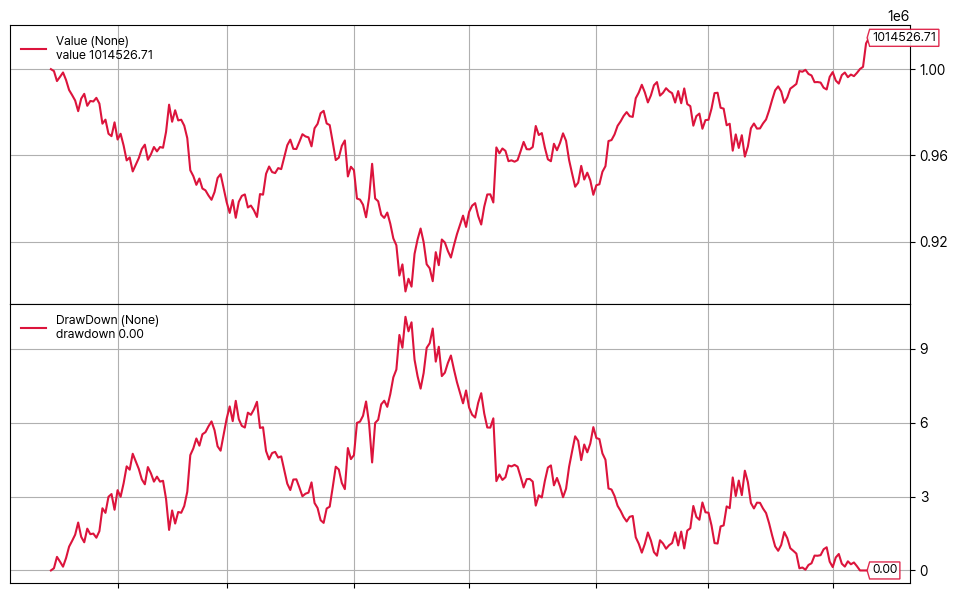

In [219]:
############################################################
# Backtesting Mean CVaR Strategy
############################################################

assets = returns.columns.tolist()
weights = models['CVaR']

dd, cagr, sharpe = backtest(assets_prices,
                            AssetAllocation,
                            start=start,
                            end=end,
                            plot=True)

In [196]:
############################################################
# Show CVaR Strategy Stats 
############################################################

print(f"Max Drawdown: {dd:.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Sharpe: {sharpe:.3f}")

Max Drawdown: 10.31%
CAGR: 0.27%
Sharpe: 0.074


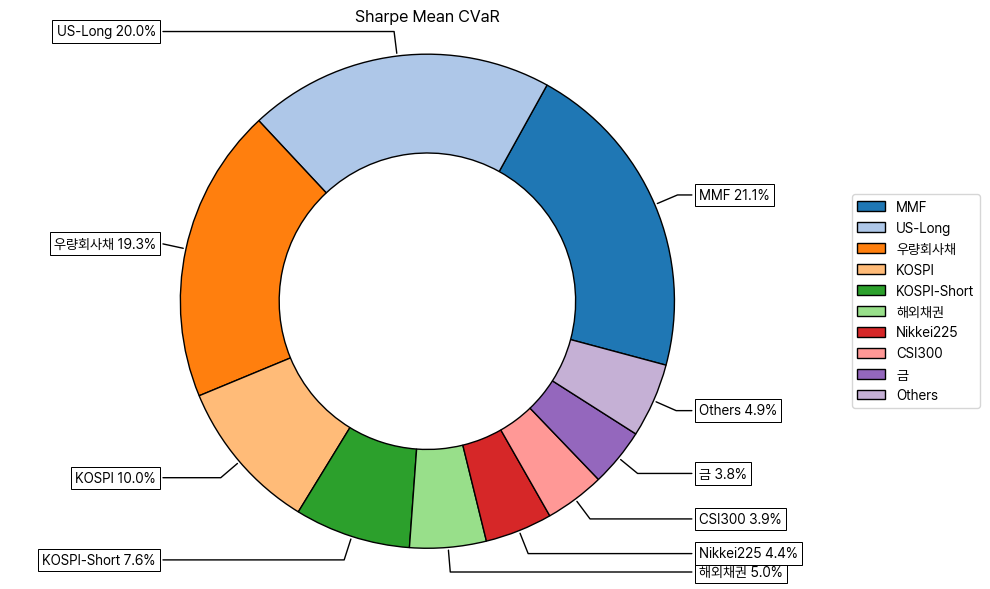

In [197]:
############################################################
# Plotting the composition of the last CVaR portfolio
############################################################

w = pd.DataFrame(models['CVaR'].iloc[-1,:])

# We need matplotlib >= 3.3.0 to use this function
ax = rp.plot_pie(w=w, title='Sharpe Mean CVaR', others=0.05, nrow=25, cmap = "tab20", 
                 height=6, width=10, ax=None)

#w.plot.pie(subplots=True, figsize=(8, 8))

In [198]:
############################################################
# Composition per Asset
############################################################

w_classes = pd.concat([asset_classes.set_index('Assets'), w], axis=1)
w_classes.rename(columns={1270 : 'Weights'}, inplace=True)
w_classes = w_classes.sort_values('Class')
w_classes

,Class,Weights
국채10년,Bond,0.0000%
우량회사채,Bond,19.2938%
해외채권,Bond,5.0000%
WTI,COM,1.1973%
금,COM,3.8027%
MMF,Cash,21.1225%
KOSDAQ,DS,0.0000%
KOSPI,DS,10.0000%
CSI300,FS,3.9240%
Nikkei225,FS,4.4089%


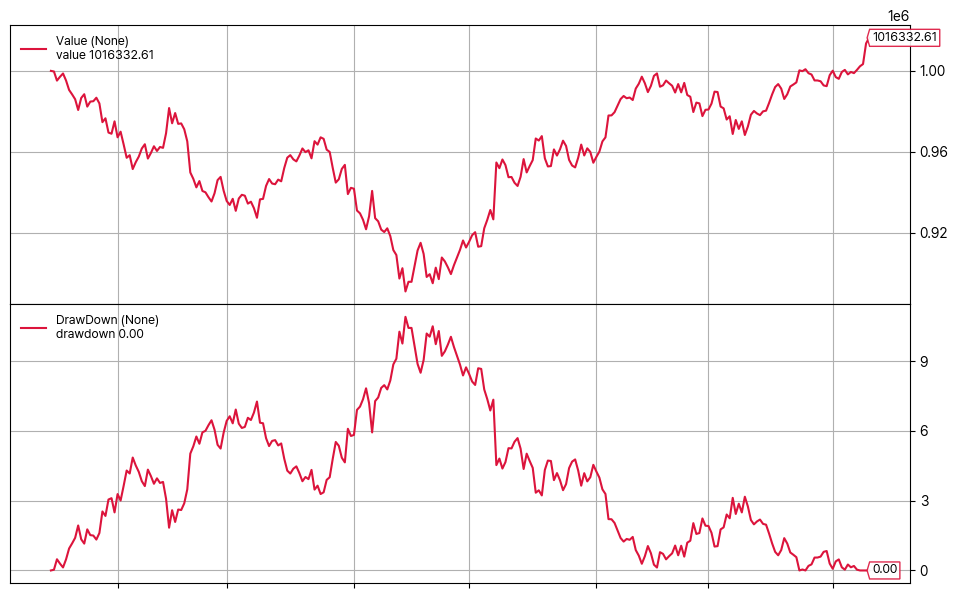

In [199]:
############################################################
# Backtesting Mean Worst Realization Strategy
############################################################

assets = returns.columns.tolist()
weights = models['WR']

dd, cagr, sharpe = backtest(assets_prices,
                            AssetAllocation,
                            start=start,
                            end=end,
                            plot=True)

In [200]:
############################################################
# Show Worst Realization Strategy Stats 
############################################################

print(f"Max Drawdown: {dd:.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Sharpe: {sharpe:.3f}")

Max Drawdown: 10.90%
CAGR: 0.31%
Sharpe: 0.091


In [201]:
models['WR']

,CSI300,KOSDAQ,KOSPI,KOSPI-Short,MMF,Nikkei225,S&P500,STOXX50,US-Long,US-Short,WTI,국채10년,금,우량회사채,해외채권
1033,3.5204%,0.0000%,10.0000%,10.9549%,1.0000%,0.0000%,5.0620%,1.4176%,20.0000%,0.0000%,0.6014%,0.0000%,4.3986%,38.0451%,5.0000%
1090,3.5204%,0.0000%,10.0000%,10.9549%,1.0000%,0.0000%,5.0620%,1.4176%,20.0000%,0.0000%,0.6014%,0.0000%,4.3986%,38.0451%,5.0000%
1151,4.7814%,0.0000%,10.0000%,8.6396%,1.3604%,3.2927%,0.0000%,1.9259%,20.0000%,0.0000%,0.2904%,0.0000%,4.7096%,40.0000%,5.0000%
1211,12.3336%,0.0000%,10.0000%,17.6517%,1.0017%,0.0000%,6.8805%,7.1324%,20.0000%,0.0000%,0.3664%,0.0000%,4.6336%,15.0000%,5.0000%
1270,3.8945%,0.0000%,10.0000%,5.0150%,22.8837%,4.2256%,0.0000%,2.4019%,20.0000%,0.0000%,0.0000%,0.0000%,5.0000%,21.5793%,5.0000%


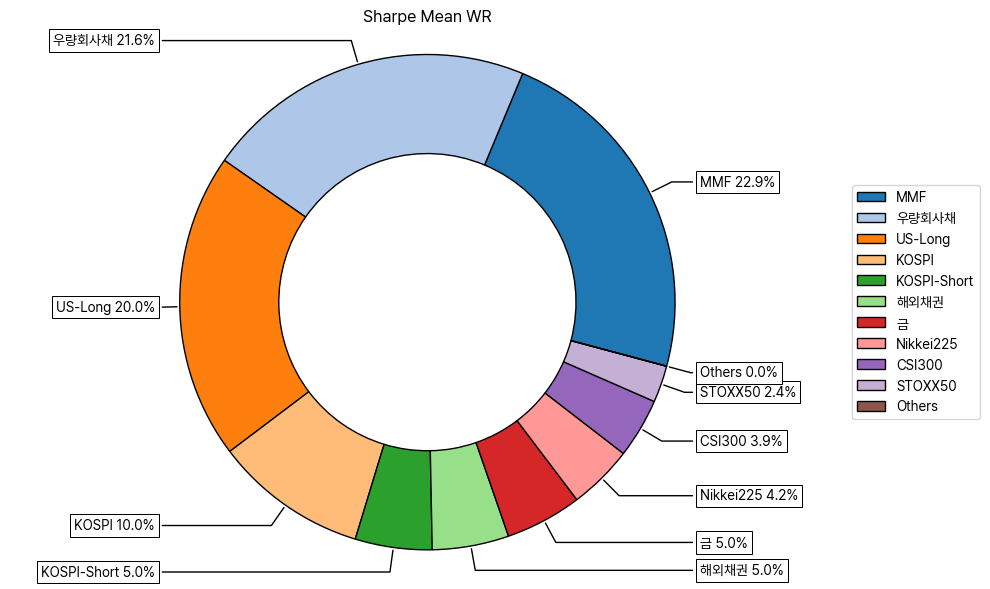

In [212]:
############################################################
# Plotting the composition of the last WR portfolio
############################################################

w = pd.DataFrame(models['WR'].iloc[-1,:])
# w.plot.pie(subplots=True, figsize=(8, 8))

# We need matplotlib >= 3.3.0 to use this function
ax = rp.plot_pie(w=w, title='Sharpe Mean WR', others=0.01, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

In [213]:
############################################################
# Composition per Asset
############################################################

w_classes = pd.concat([asset_classes.set_index('Assets'), w], axis=1)
w_classes.rename(columns={1270 : 'Weights'}, inplace=True)
w_classes = w_classes.sort_values('Class')
w_classes

,Class,Weights
국채10년,Bond,0.0000%
우량회사채,Bond,21.5793%
해외채권,Bond,5.0000%
WTI,COM,0.0000%
금,COM,5.0000%
MMF,Cash,22.8837%
KOSDAQ,DS,0.0000%
KOSPI,DS,10.0000%
CSI300,FS,3.8945%
Nikkei225,FS,4.2256%


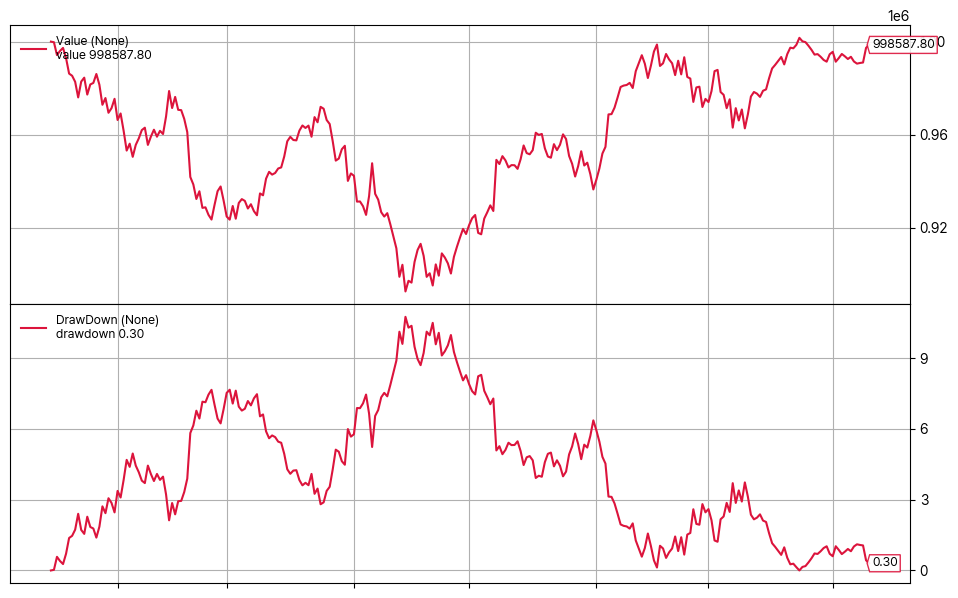

In [206]:
############################################################
# Backtesting Mean CDaR Strategy
############################################################

assets = returns.columns.tolist()
weights = models['CDaR']

dd, cagr, sharpe = backtest(assets_prices,
                            AssetAllocation,
                            start=start,
                            end=end,
                            plot=True)

In [207]:
############################################################
# Show CDaR Strategy Stats 
############################################################

print(f"Max Drawdown: {dd:.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Sharpe: {sharpe:.3f}")

Max Drawdown: 10.75%
CAGR: -0.01%
Sharpe: 0.015


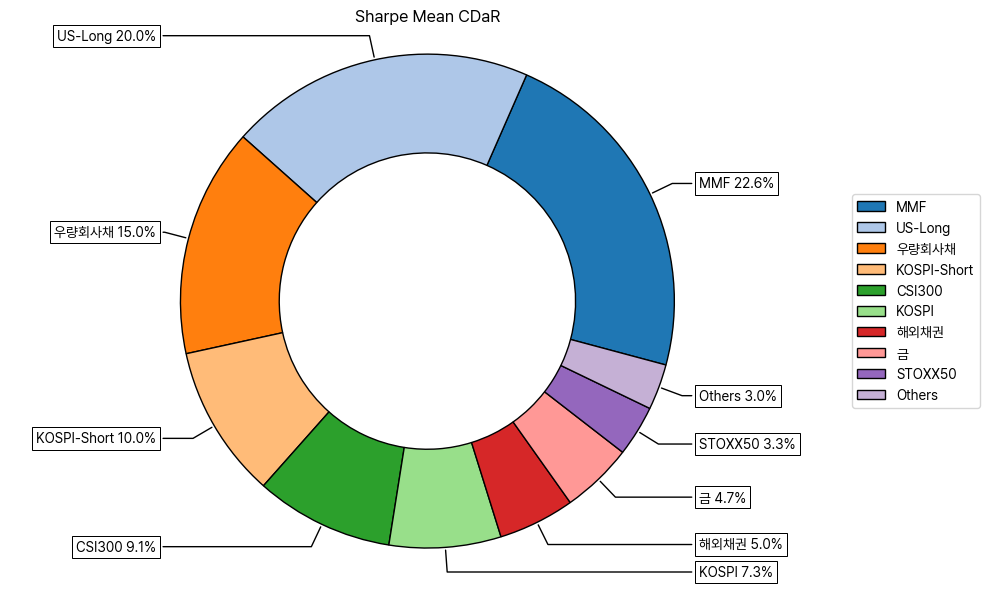

In [210]:
############################################################
# Plotting the composition of the last CDaR portfolio
############################################################

w = pd.DataFrame(models['CDaR'].iloc[-1,:])
# w.plot.pie(subplots=True, figsize=(8, 8))

# We need matplotlib >= 3.3.0 to use this function
ax = rp.plot_pie(w=w, title='Sharpe Mean CDaR', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

In [209]:
############################################################
# Composition per Asset
############################################################

w_classes = pd.concat([asset_classes.set_index('Assets'), w], axis=1)
w_classes.rename(columns={1270 : 'Weights'}, inplace=True)
w_classes = w_classes.sort_values('Class')
w_classes

,Class,Weights
국채10년,Bond,0.0000%
우량회사채,Bond,15.0000%
해외채권,Bond,5.0000%
WTI,COM,0.3025%
금,COM,4.6975%
MMF,Cash,22.5876%
KOSDAQ,DS,2.6864%
KOSPI,DS,7.3136%
CSI300,FS,9.0590%
Nikkei225,FS,0.0000%


## 4. Conclusion

In this example, the best strategy in terms of performance is __WR__ . The ranking of strategies in base of performance follows:

1. WR (7.03%): Worst Scenario or Minimax Model.
1. SPY (6.53%): Buy and Hold SPY.
1. CVaR (5.73%): Conditional Value at Risk.
1. MV (5.68%): Mean Variance.
1. CDaR (4.60%): Conditional Drawdown at Risk.

On the other hand, the best strategy in terms of Sharpe Ratio is __MV__ . The ranking of strategies in base of Sharpe Ratio follows:

1. MV (0.701): Mean Variance.
1. CVaR (0.694): Conditional Value at Risk.
1. WR (0.681): Worst Scenario or Minimax Model.
1. SPY (0.679): Buy and Hold SPY.
1. CDaR (0.622): Conditional Drawdown at Risk.